In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import reshape
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, scale
from sklearn.utils import resample, shuffle
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score, silhouette_score, homogeneity_score, mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV


def balance(data): #sample it down to 1200 to balance out
    zero = data[data['Potability']==0] #has 1200
    one = data[data['Potability']==1] #has 811
    resampledData = resample(one, n_samples=1200)
    updatedData = shuffle(pd.concat([zero, resampledData]))
    return updatedData

def variableClean(data):
    indepVariable = data.drop('Potability', axis=1).copy()
    depVariable = data['Potability'].copy()
    scal = StandardScaler()
    features = indepVariable.columns
    indepVariable[features] = scal.fit_transform(indepVariable[features])
    return indepVariable, depVariable

def normalizeFeatures(dataX1, dataX2):
    preprocMinMaxScaler = preprocessing.MinMaxScaler()
    dataX1 = preprocMinMaxScaler.fit_transform(dataX1)
    dataX2 = preprocMinMaxScaler.fit_transform(dataX2)
    return [dataX1, dataX2]

def plotSSE(clusters, dataX):
    sse = {}
    for cluster in clusters:
        kMeans = KMeans(n_clusters=cluster, max_iter=700).fit(dataX)
        sse[cluster] = kMeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("SSE vs Clusters")
    plt.xlabel("Cluster #s")
    plt.ylabel("Sum of Squared Errors")
    plt.show()
    
def getScores(normX, y):
    kmeans = KMeans(n_clusters=2, n_init=50, max_iter=1000, random_state=44).fit(normX)
    accuracyScore = accuracy_score((1-kmeans.labels_), y)
    adjustedMutualScore = adjusted_mutual_info_score((1-kmeans.labels_), y)
    return [accuracyScore, adjustedMutualScore]

def plotSilhouette(dataX, datay, clusters):
    silhouette = {}
    homogenity = {}
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=700, random_state=44).fit(dataX)
        label = kmeans.labels_
        silhouette_coeff = silhouette_score(dataX, label)
        homogenity_score = homogeneity_score(datay, label)
        silhouette[cluster] = silhouette_coeff
        homogenity[cluster] = homogenity_score
    plt.figure()
    plt.plot(list(silhouette.keys()), list(silhouette.values()), label="Silhouette")
    plt.plot(list(homogenity.keys()), list(homogenity.values()), label="Homogeneity")
    plt.legend()
    plt.title("silhouette & homogenity")
    plt.ylabel("silhouette coefficient values")
    plt.xlabel("Cluster #s")
    plt.show()
    
def plotSilhouetteEM(dataX, datay, clusters):
    silhouetteEM = {}
    homogenityEM = {}
    gaussianScore = {}
    for cluster in clusters:
        gmm = GaussianMixture(n_components=cluster, max_iter=200, random_state=44, n_init=5).fit(dataX)
        label = gmm.predict(dataX)
        silhouette_coeff = silhouette_score(dataX, label)
        homogenity_score = homogeneity_score(datay, label)
        silhouetteEM[cluster] = silhouette_coeff
        homogenityEM[cluster] = homogenity_score
        gaussianScore[cluster] = gmm.score(dataX)
    plt.figure()
    plt.plot(list(silhouetteEM.keys()), list(silhouetteEM.values()), label="Silhouette")
    plt.plot(list(homogenityEM.keys()), list(homogenityEM.values()), label="Homogeneity")
    plt.legend()
    plt.title("Expectation Maximization")
    plt.ylabel("silhouette coefficient values")
    plt.xlabel("Cluster #s")
    plt.show()
    
    plt.figure()
    plt.plot(list(gaussianScore.keys()), list(gaussianScore.values()), label="log-likelihood")
    plt.legend()
    plt.title("Log Likelihood")
    plt.ylabel("log likelihood score")
    plt.xlabel("Cluster #s")
    plt.show()
    
def gaussianAccuracy(dataX, datay):
    gmm = GaussianMixture(n_components=2, max_iter=200, random_state=44, n_init=5).fit(dataX)
    label = gmm.predict(dataX)
    accuracy = accuracy_score((1-label), datay)
    return accuracy

def plotRMSE(X_values, dimensions):
    rec_errors = {}
    for dimension in dimensions:
        grp = GaussianRandomProjection(n_components=dimension, random_state=44)
        x_prime = grp.fit_transform(X_values)
        
        recon_A = np.linalg.pinv(grp.components_.T)
        reconstructedDot = np.dot(x_prime, recon_A)
        rec_err = mean_squared_error(X_values, reconstructedDot)
        rec_errors[dimension] = rec_err
        
    plt.figure()
    plt.plot(list(rec_errors.keys()), list(rec_errors.values()))
    plt.ylabel("RMSE")
    plt.xlabel("# of Dimensions")
    plt.show()


In [4]:
hd_df = pd.read_csv('/Users/jacobseo/cs7641/assignment3/data/processed.cleveland.data', header=None)
hd_df.columns = ['age','sex','chestPain','restingBloodPressure','cholesterol','fastingBloodSugar','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

hd_messy_df = hd_df.loc[(hd_df['ca'] == '?') | (hd_df['thal'] == '?')]
hd_clean_df = hd_df.loc[(hd_df['ca'] != '?') & (hd_df['thal'] != '?')]
##data Split to independent variable
hd_X = hd_clean_df.drop('num', axis=1).copy()
hd_y = hd_clean_df['num'].copy()

## category attriutes into binary format
pd.get_dummies(hd_X, columns=['chestPain']).head()
hd_X_encoded = pd.get_dummies(hd_X, columns=['chestPain', 'restecg','slope','thal'])
hd_y_nonZeroIndex = hd_y > 0
hd_y[hd_y_nonZeroIndex] = 1

water_original = pd.read_csv('/Users/jacobseo/cs7641/assignment3/data/water_potability.csv')
water_df = water_original.copy()
##Data source: https://www.kaggle.com/adityakadiwal/water-potability
#PH, Sulfate, and Trihalomethanes have NaN values are missing

water_df.isnull().sum()
water_df = water_df.dropna()
water_df.isnull().sum()

water_df = balance(water_df)
water_df.Potability.value_counts()

water_X, water_y = variableClean(water_df)

min_max_scaler = preprocessing.MinMaxScaler()
hdX = min_max_scaler.fit_transform(hd_X)
hdX_df = pd.DataFrame(hdX)

min_max_scaler = preprocessing.MinMaxScaler()
waterX = min_max_scaler.fit_transform(water_X)
waterX_df = pd.DataFrame(waterX)

clusters = list(range(2, 40, 1))

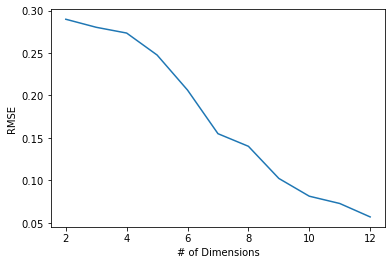

In [12]:
##Heart Disease
dimensions_hd = list(range(2,13,1))
plotRMSE(hdX_df.values, dimensions_hd)
##10 for heart disease

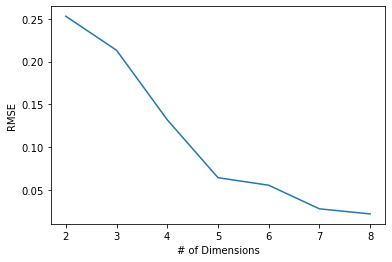

In [13]:
##Water Potability
dimensions_water = list(range(2,9,1))
plotRMSE(waterX_df.values, dimensions_water)
##7 for water

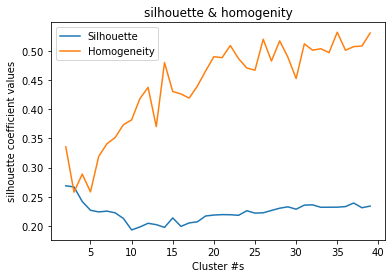

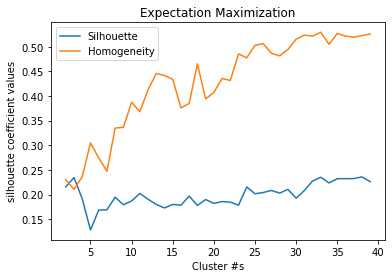

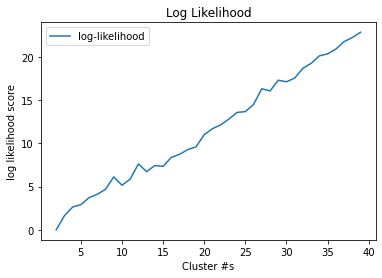

In [17]:
##K-means Clustering Heart Disease
rp_hd = GaussianRandomProjection(n_components=10)
rpX_hd = rp_hd.fit_transform(hdX_df.values)
plotSilhouette(rpX_hd, hd_y, clusters)
plotSilhouetteEM(rpX_hd, hd_y, clusters)

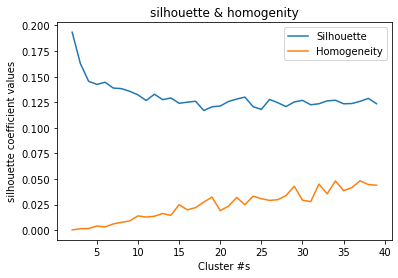

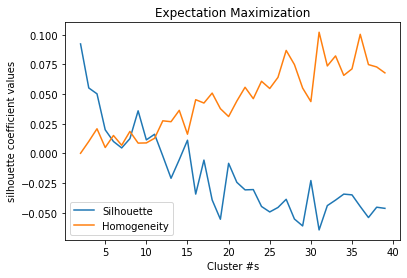

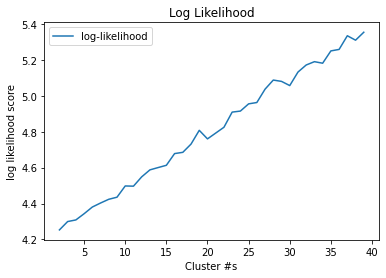

In [18]:
##K-means Clustering Potable Water
rp_water = GaussianRandomProjection(n_components=7)
rpX_water = rp_water.fit_transform(waterX_df.values)
plotSilhouette(rpX_water, water_y, clusters)
plotSilhouetteEM(rpX_water, water_y, clusters)

In [20]:
##Neural Network Heart Disease
#rp_hd = GaussianRandomProjection(n_components=10)
#rpX_hd = rp_hd.fit_transform(hdX_df.values)

nn = MLPClassifier()
nn.fit(rpX_hd, hd_y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(rpX_hd, hd_y, random_state=42)

params = {
    'hidden_layer_sizes': [(2,),(4,),(8,),(5,5),(10,10),(50,50),(30,70),(70,30)],
    'alpha': [0.7, 0.5, 0.3, 0.2],
}

gs = GridSearchCV(MLPClassifier(random_state=42, max_iter=2000), param_grid=params, cv=10, n_jobs=-1, verbose=10, return_train_score=True, scoring='f1')
gs.fit(X_train, y_train)

##Best results
optimal_params = gs.best_params_
best_score= gs.best_score_
print('optimal_params::', optimal_params)
print('best_score::', best_score)


Fitting 10 folds for each of 32 candidates, totalling 320 fits
optimal_params:: {'alpha': 0.7, 'hidden_layer_sizes': (10, 10)}
best_score:: 0.8053721424774057


(0.0, 1.0)

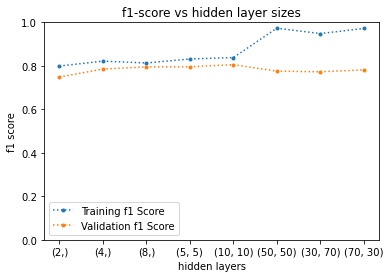

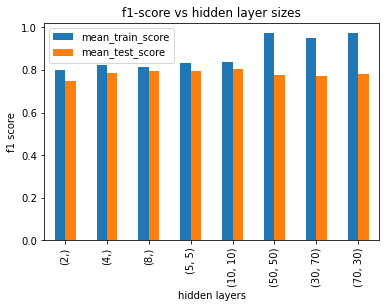

In [25]:
results_data = pd.DataFrame(gs.cv_results_)
optimal_results_data = results_data.loc[results_data['param_alpha']==0.7] ##alpha optimal is 0.7 here
optimal_results_data

##Grid Search Plotting
fig, ax = plt.subplots()
optimal_results_data.plot(x='param_hidden_layer_sizes', y='mean_train_score', label='Training f1 Score', ax=ax, marker='.', ls=':')
optimal_results_data.plot(x='param_hidden_layer_sizes', y='mean_test_score', label='Validation f1 Score', ax=ax, marker='.', ls=':')

f1_score = optimal_results_data[:8].plot(x='param_hidden_layer_sizes', y=['mean_train_score','mean_test_score'], kind='bar')
f1_score.set_ylabel('f1 score')
f1_score.set_xlabel('hidden layers')
f1_score.set_title('f1-score vs hidden layer sizes')

ax.set_title('f1-score vs hidden layer sizes')
ax.set_xlabel('hidden layers')
ax.set_ylabel('f1 score')
ax.set_ylim(bottom=0.0, top=1.0)

[learning_curve] Training set sizes: [  2   8  13  18  24  29  35  40  45  51  56  62  67  72  78  83  88  94
  99 105 110 115 121 126 132 137 142 148 153 159 164 169 175 180 186 191
 196 202 207 213 218 223 229 234 240 245 250 256 261 267]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:   19.6s remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:   33.4s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:   48.3s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:  1.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:  1.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:  1.8min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:  2.0min remaining:   30.1s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:  2.1min remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


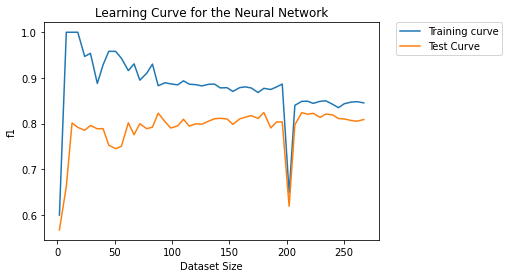

In [27]:
#learning Curve
#best param = {'alpha': 0.7, 'hidden_layer_sizes': (8, )}
optimal_df = MLPClassifier(random_state=42, max_iter=2000, alpha=0.7, hidden_layer_sizes=(10,10))
train_sizes, train_scores, test_scores = learning_curve(optimal_df, rpX_hd, hd_y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("f1")
plt.title("Learning Curve for the Neural Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)